In [1]:
# import os
# import urllib
# from getpass import getpass

# user = input('User name: ')
# password = getpass('Password: ')
# password = urllib.parse.quote(password)
# repo_address = input('Repo Address: ')
# branch_name = input('Branch name: ')

# cmd_string = 'git clone https://{}:{}@github.com/{}.git -b {}'.format(
#     user, password, repo_address, branch_name
# )

# os.system(cmd_string)
# cmd_string, password = "", ""

In [2]:
import sys
sys.path.append("Denoised-Smoothing-TF")

from models import dncnn

from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

In [3]:
try: 
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: 
    strategy = tf.distribute.MirroredStrategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of accelerators:  4


In [4]:
# from google.colab import auth
# auth.authenticate_user()

In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


In [6]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
EPOCHS = 90 
START_LR = 1e-3
AUTO = tf.data.AUTOTUNE

In [7]:
# Augmentation pipeline
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomCrop(32, 32),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(BATCH_SIZE * 100)
    .map(lambda x: (tf.image.convert_image_dtype(x, tf.float32)), 
         num_parallel_calls=AUTO)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Test dataset
test_ds = (
    tf.data.Dataset.from_tensor_slices(x_test)
    .map(lambda x: (tf.image.convert_image_dtype(x, tf.float32)), 
         num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Compute the mean and the variance of the training data for normalization
data_augmentation.layers[0].adapt(x_train/255.) # Notice the scaling step

In [8]:
class Trainer(tf.keras.Model):
    def __init__(self, denoiser, classifier):
        super(Trainer, self).__init__()
        self.denoiser = denoiser
        self.classifier = classifier
    
    def train_step(self, clean_inputs):
        batch_size = tf.shape(clean_inputs)[0]
        clean_inputs = tf.cast(clean_inputs, tf.float32)

        if self.classifier is not None:
            targets = self.classifier(clean_inputs, training=False)
        else:
            targets = clean_inputs

        with tf.GradientTape() as tape:
            noise = tf.random.normal(shape=(batch_size, 32, 32, 3),
                                     stddev=0.25)
            noisy_inputs = clean_inputs + noise
            clean_predictions = self.denoiser(noisy_inputs, training=True)

            if self.classifier is not None:
                clean_predictions = self.classifier(clean_predictions, 
                                                    training=False)
                loss = self.compiled_loss(targets, clean_predictions)
                loss = tf.nn.compute_average_loss(loss, 
                                                  global_batch_size=BATCH_SIZE)
            else:
                loss = self.compiled_loss(targets, clean_predictions)
                loss /= tf.cast(tf.reduce_prod(tf.shape(targets)[1:]), tf.float32)
                loss = tf.nn.compute_average_loss(loss, 
                                                  global_batch_size=BATCH_SIZE)

        trainable_vars = self.denoiser.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss}

    def test_step(self, clean_inputs):
        batch_size = tf.shape(clean_inputs)[0]
        clean_inputs = tf.cast(clean_inputs, tf.float32)

        if self.classifier is not None:
            targets = self.classifier(clean_inputs, training=False)
        else:
            targets = clean_inputs

        noise = tf.random.normal(shape=(batch_size, 32, 32, 3),
                                    stddev=0.25)
        noisy_inputs = clean_inputs + noise
        clean_predictions = self.denoiser(noisy_inputs, training=True)

        if self.classifier is not None:
            clean_predictions = self.classifier(clean_predictions, 
                                                            training=False)
            loss = self.compiled_loss(targets, clean_predictions)
            loss = tf.nn.compute_average_loss(loss, 
                                                  global_batch_size=BATCH_SIZE)
        else:
            loss = self.compiled_loss(targets, clean_predictions)
            loss /= tf.cast(tf.reduce_prod(tf.shape(targets)[1:]), tf.float32)
            loss = tf.nn.compute_average_loss(loss, 
                                                global_batch_size=BATCH_SIZE)

        return {"loss": loss}

In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)

## Training with the stability objective

From [this blog post](https://www.microsoft.com/en-us/research/blog/denoised-smoothing-provably-defending-pretrained-classifiers-against-adversarial-examples/):

> given a classifier $F$ attached to the denoiser $\mathcal{D}_{\theta}$, minimize the cross-entropy loss between the prediction of $F(\mathcal{D}_{theta})$ at the noisy input $x_i + \delta
$ and the prediction of the classifier at the clean data point $x_i$

$$\begin{align}L_{\text{Stab}}&=\mathbb{E}_{\mathcal{S}, \delta} \mathcal{\ell_\text{CE}}(F(\mathcal{D}_\theta(x_i + \delta)), f(x_i)) \quad \text{where} \; \delta \sim \mathcal{N}(0, \sigma^2 I) \; \end{align}$$

In [10]:
with strategy.scope():
    pretrained_classifier = tf.keras.models.load_model("gs://denoised-smoothing-tf/resnet20_classifier")
    denoiser = Trainer(dncnn.get_dncnn(data_augmentation), pretrained_classifier)
    denoiser.denoiser.save("gs://denoised-smoothing-tf/initial_denoiser")
    denoiser.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=START_LR,
                        momentum=0.9),
                     loss=tf.keras.losses.CategoricalCrossentropy(reduction="none")
    )

history = denoiser.fit(train_ds,
            steps_per_epoch=len(x_train)//BATCH_SIZE,
            validation_data=test_ds,
            epochs=EPOCHS,
            callbacks=[reduce_lr])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

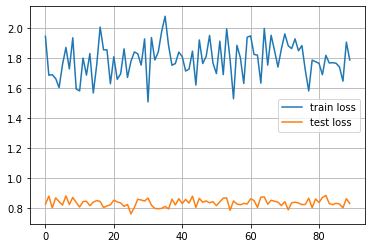

INFO:tensorflow:Assets written to: gs://denoised-smoothing-tf/denoiser_stability/assets


In [11]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="test loss")
plt.grid()
plt.legend()
plt.show()

denoiser.denoiser.save("gs://denoised-smoothing-tf/denoiser_stability")

## With MSE objective

In [12]:
with strategy.scope():
    initial_denoiser = tf.keras.models.load_model("gs://denoised-smoothing-tf/initial_denoiser")
    denoiser = Trainer(initial_denoiser, classifier=None)
    denoiser.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=START_LR,
                        momentum=0.9),
                     loss=tf.keras.losses.MeanSquaredError(reduction="none")
    )

history = denoiser.fit(train_ds,
            steps_per_epoch=len(x_train)//BATCH_SIZE,
            validation_data=test_ds,
            epochs=EPOCHS,
            callbacks=[reduce_lr])

Epoch 1/90
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1
97/97 [==============================] - 30s 116ms/step - loss: 51.0990 - val_loss: 0.0028
Epoch 2/90
97/97 [==============================] - 6s 59ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 3/90
97/97 [==============================] - 6s 59ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 4/90
97/97 [==============================] - 6s 59ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 5/90
97/97 [==============================] - 6s 59ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 6/90
97/97 [==============================] - 6s 59ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 7/90
97/97 [==============================] - 6s 59ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 8/90
97/97 [==============================] - 6s 61ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 9/90
97/97 [===============

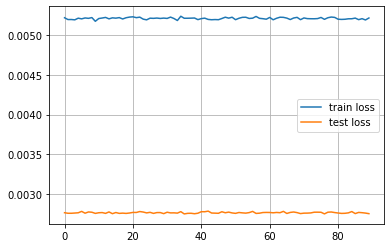

INFO:tensorflow:Assets written to: gs://denoised-smoothing-tf/denoiser_mse/assets


In [13]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="test loss")
plt.grid()
plt.legend()
plt.show()

denoiser.denoiser.save("gs://denoised-smoothing-tf/denoiser_mse")